# 1) Setup

## 1a) Library functions

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from time import time
from datetime import datetime, timedelta
from copy import copy
import os
import random

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import sklearn as skl
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.inspection import permutation_importance

#Tensorflow
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras import utils
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras import backend as K

#LTR tensorflow
from tensorflow.keras import layers, activations, losses, Model, Input
from tensorflow.nn import leaky_relu
from itertools import combinations
from tensorflow.keras.utils import plot_model, Progbar

#tensorflow rankings
import tensorflow_ranking as tfr

# Set random seed for reproducability
#tensorflow.random.set_seed(0)

print("done")

done


## 1b) Helper functions

In [2]:
def ListUnion(l1, l2):
    union = list(set(l1) | set(l2))
    return union

In [3]:
def regression_analysis(X,Y, ylabel = "Return for our strategy"):
    #remove nans
    #X = X[~np.isnan(Y)]
    #Y = Y[~np.isnan(Y)]
    #X = X[~np.isnan(X)]
    #Y = Y[~np.isnan(X)]
    res = pd.DataFrame(index = range(len(X)))
    res["X"] = X
    res["Y"] = Y
    res = res.dropna(how = "any")
    X = np.array(res["X"])
    Y = np.array(res["Y"])
    
    #fit OLS
    X2 = sm.add_constant(X)
    model = sm.OLS(Y, X2).fit() ## sm.OLS(output, input)
    coeff = [model.params[1],model.params[0]]
    
    #correlation
    corr = sp.stats.pearsonr(X,Y)
    
    #plot
    plt.scatter(X,Y,marker = ".");
    x_plot = np.arange(X.min(),X.max(),0.01)
    plt.plot(x_plot,np.polyval(coeff,x_plot),color = "orange");
    plt.xlabel("Return for index")
    plt.ylabel(ylabel)
    #title = "alpha = %.5f  |  beta = %.5f, \n pval_alpha = %.5f  |  correlation = %.5f" % (model.params[0],model.params[1],model.pvalues[0],corr[0])
    title = "alpha = %.5f  |  beta = %.5f  |  corr = %.5f" % (model.params[0],model.params[1],corr[0])
    plt.title(title)
    return;


In [4]:
def get_TrainTest(df_train,df_test,features, target, is_regression = True, is_ltr = False):
    """
    Get Train & Test matrices in correct format
    """
    x_train = df_train[features].values
    y_train = df_train[target].values
    x_test = df_test[features].values
    y_test = df_test[target].values

    #set data types
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    y_train =y_train.astype('float32')
    y_test = y_test.astype('float32')
    
    #change data type if classification
    if is_regression == False or is_regression == "brier":
        y_train = y_train > 0  #classification
        y_test = y_test > 0    #classification
        y_train = utils.to_categorical(y_train)
        y_test = utils.to_categorical(y_test)
    print ('Training Set: %d, Test Set: %d\n' % (len(x_train), len(x_test)))
    
    #provide queries if ltr
    if is_ltr:
        #queries
        q_train = df_train["month"].values
        q_test = df_test["month"].values
        #reformat output for ltr as rankings
        y_train = df_train.groupby("month")[target].rank("dense", ascending = False).values
        y_test = df_test.groupby("month")[target].rank("dense", ascending = False).values
        y_train =y_train.astype('int')
        y_test = y_test.astype('int')
        return x_train, y_train, q_train, x_test, y_test, q_test
    else:
        return x_train, y_train, x_test, y_test

In [5]:
def get_TrainTestValidate(df_train,df_test,df_validate,features, target, is_regression = True, is_ltr = False):
    """
    Get Train & Test matrices in correct format
    """
    x_train = df_train[features].values
    y_train = df_train[target].values
    x_test = df_test[features].values
    y_test = df_test[target].values
    x_validate = df_validate[features].values
    y_validate = df_validate[target].values

    #set data types
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_validate = x_validate.astype('float32')
    y_train =y_train.astype('float32')
    y_test = y_test.astype('float32')
    y_validate =y_validate.astype('float32')
    
    #change data type if classification
    if is_regression == False or is_regression == "brier":
        y_train = y_train > 0  #classification
        y_test = y_test > 0    #classification
        y_validate = y_validate > 0    #classification
        y_train = utils.to_categorical(y_train)
        y_test = utils.to_categorical(y_test)
        y_validate = utils.to_categorical(y_validate)
    print ('Training Set: %d, Test Set: %d, Validation Set: %d \n' % (len(x_train), len(x_test), len(x_validate)))
    
    #provide queries if ltr
    if is_ltr:
        #queries
        q_train = df_train["month"].values
        q_test = df_test["month"].values
        q_validate = df_validate["month"].values
        #reformat output for ltr as rankings
        y_train = df_train.groupby("month")[target].rank("dense", ascending = False).values
        y_test = df_test.groupby("month")[target].rank("dense", ascending = False).values
        y_validate = df_validate.groupby("month")[target].rank("dense", ascending = False).values
        y_train =y_train.astype('int')
        y_test = y_test.astype('int')
        y_validate = y_validate.astype('int')
        return x_train, y_train, q_train, x_test, y_test, q_test, x_validate, y_validate, q_validate
    else:
        return x_train, y_train, x_test, y_test, x_validate, y_validate

In [6]:
def custom_brier(y_actual,y_pred):
    brier_score = tf.reduce_mean((y_actual - y_pred) ** 2, axis=1)
    return brier_score

In [7]:
def create_NN(hidden, dropout, input_dim, is_regression = True, is_search = False, std =  0.01, seed = 1, learning_rate = 0.1):
    """
    Create MLP regression / classifier with random initialisation, Batch Normalisation & dropout
    """
    model = Sequential()
    #input layer
    model.add(Dense(hidden[0], input_dim=input_dim, activation='relu',kernel_initializer=initializers.RandomNormal(stddev=std, seed = seed)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5, seed = seed))
    #hidden layers
    for i in range(1,len(hidden)):
        model.add(Dense(hidden[i], input_dim=hidden[i-1], activation='relu',kernel_initializer=initializers.RandomNormal(stddev=std, seed = seed)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout, seed = seed))
    #output layer
    if is_regression:
        model.add(Dense(1, input_dim=hidden[-1], activation=None,kernel_initializer=initializers.RandomNormal(stddev=std, seed = seed)))
    else:
        model.add(Dense(2, input_dim=hidden[-1], activation="softmax",kernel_initializer=initializers.RandomNormal(stddev=std, seed = seed)))
    
    if is_search:
        opt = optimizers.Adam(learning_rate=learning_rate)
        if is_regression:
            model.compile(optimizer = opt, loss = 'mean_squared_logarithmic_error', metrics = ['mean_squared_logarithmic_error'])
        else:
            if is_regression == "brier":
                model.compile(optimizer = opt, loss = custom_brier, metrics = ['AUC'])
            else:
                model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['AUC'])
            
    return model
    

In [8]:
def train_NN(model, x_train, y_train, x_test, y_test, learning_rate = 0.1, is_regression = True,is_brier = False, num_epochs = 50, plot_graph = False):
    """
    Train NN with Adam optimiser
    """
    #create optimiser
    opt = optimizers.Adam(learning_rate=learning_rate)
    if is_regression:
        loss_fn = keras.losses.MeanSquaredLogarithmicError()
    else:
        loss_fn = keras.losses.CategoricalCrossentropy()
        if is_regression == "brier":
            loss_fn = custom_brier
    model.compile(loss=loss_fn,
                  optimizer=opt,
                  metrics=[loss_fn])
    #fit model
    history = model.fit(x_train, y_train, epochs=num_epochs, batch_size=500, validation_data=(x_test, y_test), verbose = 0)

    #plot fitting results
    if plot_graph:
        epoch_nums = range(1,num_epochs+1)
        training_loss = history.history["loss"]
        validation_loss = history.history["val_loss"]
        plt.plot(epoch_nums, training_loss)
        plt.plot(epoch_nums, validation_loss)
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend(['training', 'validation'], loc='upper right')
        plt.show()
    
    return model, history

In [9]:
def get_Matrices(model, x_test, df_test, company_name = "TICKER", is_regression = True, pct = 0.1, is_short = False, max_ret = 10):
    """
    create return & weight matrices
    """
    # predict outputs
    model_output = model.predict(x_test)
    if is_regression == False:
        model_output = model_output[:,1]
    #map to original test dataframe for price data
    predictions = df_test.iloc[:,:5]
    predictions["pred"] = model_output
    
    #rank predictions
    predictions["rank"] = predictions.groupby("month")["pred"].rank("dense", ascending = False)
    rank_table = pd.pivot_table(predictions, values="rank", index=["month"],
                    columns=[company_name])
    
    #create weight matrix
    weight_matrix = pd.DataFrame(index = rank_table.index, columns = rank_table.columns, data = 0)
    weight_matrix[rank_table.lt(np.floor(pct*rank_table.max(axis = 1))+1, axis = 0)] = 1/np.transpose(np.tile(np.floor(rank_table.max(axis = 1)*pct),(len(rank_table.columns),1)))
    # include shorts
    if is_short:
        weight_matrix[rank_table.gt(np.floor((1-pct)*rank_table.max(axis = 1))+1, axis = 0)] = -1/np.transpose(np.tile(np.floor(rank_table.max(axis = 1)*pct),(len(rank_table.columns),1)))
    
    #create returns matrix
    returns_matrix = pd.pivot_table(predictions, values="pred_target", index=["month"],
                    columns=[company_name])
    
    #backfill if returns are suspiciously high
    returns_matrix[returns_matrix > max_ret] = returns_matrix.shift()
    return returns_matrix, weight_matrix, rank_table, model_output

In [10]:
def get_Matrices_LTR(model_output, df_test, company_name = "TICKER", pct = 0.1, is_short = False, max_ret = 10, discretise = True):
    """
    create return & weight matrices
    """
    #convert to rankings
    if discretise:
        predictions = np.sign(model_output-0.5)
    else:
        predictions = model_output
    n_outputs = len(predictions)
    df_pairs = pd.DataFrame(index = range(len(predictions)))
    df_pairs[str(df_test.columns[0])] = list(df_test.iloc[pair_test[:n_outputs,0],0])
    df_pairs["month"] = query_test[:n_outputs]
    df_pairs["pred"] = predictions[:n_outputs]
    df_pairs["first"] = pair_test[:n_outputs,0]
    df_pairs["second"] = pair_test[:n_outputs,1]
    df_ranks = df_pairs.groupby(["month",df_train.columns[0]])["pred"].sum().to_frame().reset_index()
    df_ranks["rank"] = df_ranks.groupby("month")["pred"].rank("dense", ascending = False)
    df_ranks = df_ranks.merge(df_test[[company_name,"month","pred_target"]],on  =[company_name,"month"], how = "left")
    rank_table = pd.pivot_table(df_ranks, values="rank", index=["month"],
                    columns=[company_name])
    
    #create weight matrix
    weight_matrix = pd.DataFrame(index = rank_table.index, columns = rank_table.columns, data = 0)
    weight_matrix[rank_table.lt(np.floor(pct*rank_table.max(axis = 1))+1, axis = 0)] = 1/np.transpose(np.tile(np.floor(rank_table.max(axis = 1)*pct),(len(rank_table.columns),1)))
    # include shorts
    if is_short:
        weight_matrix[rank_table.gt(np.floor((1-pct)*rank_table.max(axis = 1))+1, axis = 0)] = -1/np.transpose(np.tile(np.floor(rank_table.max(axis = 1)*pct),(len(rank_table.columns),1)))
    
    #create returns matrix
    returns_matrix = pd.pivot_table(df_ranks, values="pred_target", index=["month"],
                    columns=[company_name])
    
    #backfill if returns are suspiciously high
    returns_matrix[returns_matrix > max_ret] = returns_matrix.shift()
    return returns_matrix, weight_matrix, rank_table, model_output

In [11]:
def turnover_cost(w, k):
    """
    Calculate transaction costs. k is in bps, w is a weight matrix
    """
    k = k/10000  #convert to bps
    w.fillna(value = 0, inplace=True)
    t_cost = w.diff(1).abs().sum(axis = 1) * k
    t_cost[0] = k
    return t_cost

In [12]:
def calc_returns(returns_matrix, weight_matrix, k = 3):
    """
    Calculate returns & cumulative returns, including transaction costs of k bps.
    """
    #equal weighted
    if isinstance(weight_matrix,str):
        if weight_matrix == "equal":
            rets = returns_matrix.mean(axis = 1)
            rets.index = pd.to_datetime(rets.index)
            #rets.index = rets.index.to_timestamp()   #convert periods to timestamps
            cumrets = (1+rets).cumprod()
        else:
            raise ValueError("Invalid string argument. Must be equal")
    else:
        #calculate returns using weight matrix
        rets = (weight_matrix*returns_matrix.fillna(0)).sum(axis = 1)
        rets = rets - turnover_cost(weight_matrix, k)
        rets.index = pd.to_datetime(rets.index)
        #rets.index = rets.index.to_timestamp()   #convert periods to timestamps
        #calculate cumulative returns
        cumrets = (1+rets).cumprod()
    return rets, cumrets

In [13]:
def calc_sharpe(rets, periods_per_year = 12):
    #rets = monthly returns
    n = len(rets)/periods_per_year   #no. of years
    cumrets = (1+rets).cumprod()   #cumulative returns
    #scale to average annual return and volatility
    sharpe = (cumrets[-1]**(1/n) - 1)/(np.std(rets) * np.sqrt(periods_per_year))
    return sharpe

In [14]:
def calc_mdd(returns, verbose = False):
    #maximum drawdown
    cum_rets = (1 + returns).cumprod()
    max_cumret = cum_rets.cummax()  #max previous cumret
    dd = 1 - cum_rets/max_cumret   #all drawdowns
    
    #visual check
    if verbose:
        print(cum_rets[np.argmax(dd)-2:np.argmax(dd)+2])
        print(max_cumret[np.argmax(dd)-2:np.argmax(dd)+2])
        
    #ret
    return np.max(dd), np.argmax(dd)

In [15]:
def feature_importance(model, x_test, y_test, features, n_repeats=5, random_state=1, is_regression = True):
    if is_regression:
        scoring =  "neg_mean_squared_error"
    else:
        #neg_log_loss is technically correct, but not worth rewriting permutation importance to replace predict_proba with predict
        #scoring = "neg_log_loss"
        scoring =  "neg_mean_squared_error"
    result = permutation_importance(model, x_test, y_test, n_repeats=n_repeats, random_state=random_state, scoring = scoring)
    sorted_idx = result.importances_mean.argsort()
    labels = np.array(features)

    plt.boxplot(
        result.importances[sorted_idx].T, vert=False, labels=labels[sorted_idx]
    )
    plt.title("Permutation Importances (test set)")

    plt.tight_layout()
    plt.xticks(rotation = 45)
    plt.show()
    
    features_pi = list(labels[result.importances_mean > 0])
    print("Permutation importance > 0:")
    print(features_pi)
    return result, features_pi

In [16]:
def create_pairs(query, doc_features, doc_scores):
    # put data into pairs
    xi = []  #input 1
    xj = []  #input 2
    pij = []      #target
    pair_id = []    #pair
    pair_query_id = []    #pair_query

    for q in np.unique(query):
        query_idx = np.where(query == q)[0]
        for pair_idx in combinations(query_idx, 2):

            pair_id.append(pair_idx)
            i = pair_idx[0]
            j = pair_idx[1]
            xi.append(doc_features[i])
            xj.append(doc_features[j])
            pair_query_id.append(q)

            if doc_scores[i] == doc_scores[j]:
                _pij = 0.5
            elif doc_scores[i] > doc_scores[j]:
                _pij = 1
            else: 
                _pij = 0
            pij.append(_pij)

    xi = np.array(xi)
    xj = np.array(xj)
    pij = np.array(pij)
    pair_query_id = np.array(pair_query_id)
    
    return xi, xj, pij, pair_id, pair_query_id

## 1c) Read data

In [17]:
#df_nn = pd.read_pickle("df_NeuralNetworkFeatures_fillna.pkl")
#df_nn = pd.read_pickle("df_NeuralNetworkFeatures_bloomberg.pkl")

#df_nn = pd.read_pickle("FinalMembers/df_NeuralNetworkFeatures.pkl")
df_nn = pd.read_pickle("FinalMembers/df_NNdata_withMACD.pkl")
df_nn

,PERMNO,month,pred_target,mcap,gsector,debt_assets,de_ratio,evm,pe_exi,roe,...,return_12M,macd_3_16,macd_3_24,macd_3_32,macd_6_16,macd_6_24,macd_6_32,macd_9_16,macd_9_24,macd_9_32
0,10078.0,2002-01,-0.209108,3.487959e+10,7.0,0.411,0.697,27.293,500.000,0.028,...,-0.647934,-0.262929,-0.231501,-0.219760,-0.221719,-0.205719,-0.199555,-0.202827,-0.193608,-0.189803
1,10078.0,2002-02,0.036428,2.764405e+10,7.0,0.415,0.710,42.961,-189.110,-0.053,...,-0.571823,-0.216646,-0.194353,-0.186169,-0.188457,-0.176734,-0.172316,-0.174603,-0.167914,-0.165263
2,10078.0,2002-03,-0.072562,2.865106e+10,7.0,0.415,0.710,42.961,-196.000,-0.053,...,-0.426154,-0.177402,-0.162822,-0.157666,-0.160040,-0.152124,-0.149307,-0.150313,-0.146022,-0.144473
3,10078.0,2002-04,-0.157702,2.657208e+10,7.0,0.415,0.710,42.961,-181.780,-0.053,...,-0.522195,-0.166721,-0.155574,-0.151787,-0.153857,-0.147718,-0.145694,-0.145811,-0.142731,-0.141772
4,10078.0,2002-05,-0.272859,2.236680e+10,7.0,0.418,0.719,84.523,-119.830,-0.070,...,-0.581663,-0.167745,-0.156779,-0.153132,-0.155035,-0.149098,-0.147232,-0.146903,-0.144096,-0.143314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117326,93436.0,2021-07,0.070605,6.803383e+11,3.0,0.593,1.574,104.366,460.172,0.080,...,1.401521,0.345490,0.653761,0.613442,0.806785,0.473680,0.393620,0.452413,0.346973,0.313824
117327,93436.0,2021-08,0.054042,7.283738e+11,3.0,0.554,1.325,108.001,383.188,0.122,...,0.476400,0.432947,0.573072,0.470146,0.635574,0.390181,0.329680,0.383073,0.298225,0.271048
117328,93436.0,2021-09,0.436530,7.677368e+11,3.0,0.554,1.325,108.001,403.896,0.122,...,0.807602,0.465906,0.445869,0.378184,0.506212,0.347343,0.301829,0.349888,0.281072,0.257824
117329,93436.0,2021-10,0.027612,1.118751e+12,3.0,0.554,1.325,108.001,492.500,0.122,...,1.870836,0.357049,0.351621,0.320781,0.417091,0.312689,0.272393,0.319155,0.253568,0.229752


In [18]:
df_nn.columns

Index(['PERMNO', 'month', 'pred_target', 'mcap', 'gsector', 'debt_assets',
       'de_ratio', 'evm', 'pe_exi', 'roe', 'npm', 'ps', 'ptb', 'pcf',
       'aftret_invcapx', 'CPI', 'PMI', 'PPI', 'FedFundsTargetRate', 'GDP',
       'MedianHomeSalesPrice', 'PrivateHousingStarts', 'NonFarmPayrolls',
       'Unemployment', 'MEDPTG', 'PCTUP4W', 'PCTDOWN4W', 'volume', 'gsector',
       'return_1M', 'return_3M', 'return_6M', 'return_9M', 'return_12M',
       'macd_3_16', 'macd_3_24', 'macd_3_32', 'macd_6_16', 'macd_6_24',
       'macd_6_32', 'macd_9_16', 'macd_9_24', 'macd_9_32'],
      dtype='object')

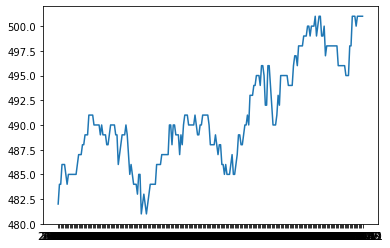

In [19]:
plt.plot(sorted(df_nn["month"].unique()),df_nn.groupby("month").apply(len))

In [20]:
np.isinf(df_nn.iloc[:,2:]).sum()

pred_target             0
mcap                    0
gsector                 0
debt_assets             0
de_ratio                0
evm                     0
pe_exi                  0
roe                     0
npm                     0
ps                      0
ptb                     0
pcf                     0
aftret_invcapx          0
CPI                     0
PMI                     0
PPI                     0
FedFundsTargetRate      0
GDP                     0
MedianHomeSalesPrice    0
PrivateHousingStarts    0
NonFarmPayrolls         0
Unemployment            0
MEDPTG                  0
PCTUP4W                 0
PCTDOWN4W               0
volume                  0
gsector                 0
return_1M               0
return_3M               0
return_6M               0
return_9M               0
return_12M              0
macd_3_16               0
macd_3_24               0
macd_3_32               0
macd_6_16               0
macd_6_24               0
macd_6_32               0
macd_9_16   

In [21]:
df_nn[df_nn["PERMNO"] == 10107]

,PERMNO,month,pred_target,mcap,gsector,debt_assets,de_ratio,evm,pe_exi,roe,...,return_12M,macd_3_16,macd_3_24,macd_3_32,macd_6_16,macd_6_24,macd_6_32,macd_9_16,macd_9_24,macd_9_32
335,10107.0,2002-01,-0.084288,3.431264e+11,7.0,0.200,0.250,22.210,27.700,0.133,...,0.043357,-0.021573,-0.087655,-0.154461,-0.067483,-0.171132,-0.278870,-0.124257,-0.272265,-0.400114
336,10107.0,2002-02,0.033768,3.159241e+11,7.0,0.204,0.257,23.933,26.761,0.125,...,-0.011186,-0.059602,-0.122392,-0.189103,-0.084116,-0.180793,-0.297302,-0.126337,-0.274670,-0.473829
337,10107.0,2002-03,-0.133477,3.266394e+11,7.0,0.204,0.257,23.933,27.665,0.125,...,0.102812,-0.079586,-0.167956,-0.257638,-0.130215,-0.289868,-0.494576,-0.185413,-0.432664,-0.787677
338,10107.0,2002-04,-0.025832,2.830405e+11,7.0,0.204,0.257,23.933,23.972,0.125,...,-0.228634,-0.139881,-0.224125,-0.299000,-0.241986,-0.472311,-0.707960,-0.331870,-0.767282,-1.240214
339,10107.0,2002-05,0.074445,2.757012e+11,7.0,0.207,0.262,24.626,22.329,0.129,...,-0.264093,-0.152124,-0.228622,-0.295343,-0.269287,-0.483383,-0.656285,-0.427333,-0.906361,-1.203284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,10107.0,2021-07,0.061528,2.145821e+12,7.0,0.583,1.400,22.727,38.816,0.460,...,0.403029,0.337336,0.330620,0.317353,0.368097,0.331072,0.309976,0.344169,0.308511,0.291020
570,10107.0,2021-08,-0.066119,2.268595e+12,7.0,0.575,1.351,26.222,37.501,0.470,...,0.350790,0.305822,0.297718,0.285770,0.334338,0.301032,0.281972,0.313511,0.281243,0.265149
571,10107.0,2021-09,0.176291,2.118598e+12,7.0,0.575,1.351,26.222,35.021,0.470,...,0.352641,0.257382,0.267799,0.266827,0.314977,0.296588,0.284543,0.309468,0.287506,0.275937
572,10107.0,2021-10,-0.001236,2.489796e+12,7.0,0.575,1.351,26.222,41.195,0.470,...,0.652867,0.317234,0.309192,0.296466,0.336460,0.303504,0.285049,0.312647,0.281988,0.266999


In [22]:
(1+ df_nn[df_nn["PERMNO"] == 10107]["pred_target"]).cumprod()

335     0.915712
336     0.946634
337     0.820280
338     0.799090
339     0.858579
         ...    
569    14.992080
570    14.000818
571    16.469037
572    16.448681
573    16.733786
Name: pred_target, Length: 239, dtype: float64

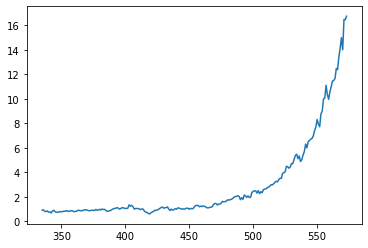

In [23]:
plt.plot((1+ df_nn[df_nn["PERMNO"] == 10107]["pred_target"]).cumprod())

## 1d) Separate data into 5-year "chunks"

In [39]:
#set seed
seed = 1
os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

#portfolio params
k = 3                #transaction costs in bps
pct = 0.1            #proportion of the portfolio long
is_short = False     #whether to use long-short portfolio

print("done")

done


In [40]:
df_train = df_nn[(df_nn["month"]>= "2002-01") & (df_nn["month"]<= "2006-12")].reset_index(drop = True)
df_test = df_nn[(df_nn["month"]>= "2007-01") & (df_nn["month"]<= "2014-12")].reset_index(drop = True)
df_validate = df_nn[(df_nn["month"]>= "2015-01") & (df_nn["month"]<= "2021-12")].reset_index(drop = True)
print("done")

done


# 2) MLP Classification

In [41]:
#model params
#hidden = [300,300,50]
#dropout = 0.3
hidden = [300,300,300, 200, 200, 100, 100, 50]
dropout = 0.1
is_regression = False
learning_rate = 0.1
num_epochs = 10

## 2a) All features

Training Set: 29259, Test Set: 46829, Validation Set: 41243 



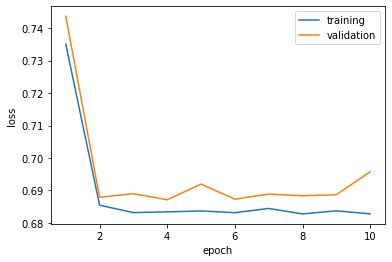

In [42]:
#model params defined in 1d
#reset seed
tf.random.set_seed(seed)
#for brier
#is_regression = "brier"
#learning_rate = 0.001
#num_epochs = 20

#split data
features = ["debt_assets", "de_ratio", "evm", "pe_exi",
               "roe", "npm","ps", "ptb", "pcf", "aftret_invcapx",
              "CPI", "PMI", "PPI", "FedFundsTargetRate", "GDP", 
              "MedianHomeSalesPrice", "PrivateHousingStarts","NonFarmPayrolls", "Unemployment",
            "MEDPTG", "PCTUP4W", "PCTDOWN4W", "volume",
             "return_1M", "return_3M", "return_6M", "return_9M", "return_12M",
           'macd_3_16', 'macd_3_24', 'macd_3_32','macd_6_16', 'macd_6_24', 
            'macd_6_32', 'macd_9_16', 'macd_9_24','macd_9_32']

target = "pred_target"
x_train, y_train, x_test, y_test, x_validate, y_validate  = get_TrainTestValidate(df_train,df_test,df_validate,features, target, is_regression = is_regression)

#create model & train
clf_all = create_NN(hidden, dropout, input_dim = len(features), is_regression = is_regression, std = 0.01, seed = seed)
#print(clf_all.summary())
clf_all, history = train_NN(clf_all, x_train, y_train, x_test, y_test, learning_rate = learning_rate, is_regression = is_regression, num_epochs = num_epochs, plot_graph = True)

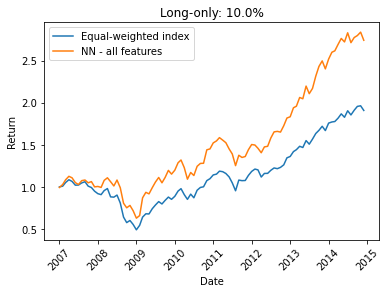

In [43]:
#calculate cost-adjusted returns & plot
#portfolio params defined in 1d

#for brier
#pct = 0.1

returns_matrix, weight_matrix, rank_table, model_output = get_Matrices(clf_all, x_test, df_test,is_regression = is_regression, pct = pct, is_short = is_short, company_name = df_train.columns[0])
rets, cumrets = calc_returns(returns_matrix, weight_matrix = weight_matrix, k = k)

#calculate return & weight matrix for base strat - i.e. long 100%
returns_matrix_equal, weight_matrix_equal, rank_table_equal, model_output = get_Matrices(clf_all, x_test, df_test,is_regression = is_regression, pct = 1, is_short = False, company_name = df_train.columns[0])
rets_equal, cumrets_equal = calc_returns(returns_matrix_equal, weight_matrix = weight_matrix_equal, k = k)

plt.plot(cumrets_equal.index, cumrets_equal, label = "Equal-weighted index")
plt.plot(cumrets.index, cumrets, label = "NN - all features")
plt.legend();
plt.xlabel("Date");
plt.xticks(rotation = 45);
plt.ylabel("Return")
#plt.yscale("log")
plt.title("Long-only: " + str(pct*100) + "%");

In [44]:
#save rankings
model_output = clf_all.predict(x_test)
if is_regression == False or is_regression == "brier":
    model_output = model_output[:,1]
#map to original test dataframe for price data
predictions = df_test.iloc[:,:5]
predictions["pred"] = model_output

#rank predictions
predictions["rank"] = predictions.groupby("month")["pred"].rank("dense", ascending = False)
pred_table = pd.pivot_table(predictions, values="pred", index=["month"],
                columns=[df_test.columns[0]])
rank_table = pd.pivot_table(predictions, values="rank", index=["month"],
                columns=[df_test.columns[0]])

rank_table.to_csv("FinalRankings/NNwithMACD_Classification_ranks.csv")
pred_table.to_csv("FinalRankings/NNwithMACD_Classification_modeloutputs.csv")

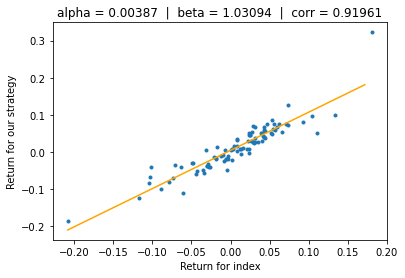

In [45]:
regression_analysis(np.array(rets_equal),np.array(rets))

In [46]:
#sharpe ratio
sharpe = calc_sharpe(rets)
print("NN sharpe: ", sharpe)
mdd = calc_mdd(rets)
print("NN mdd: ", mdd[0])

sharpe_equal = calc_sharpe(rets_equal)
print("Base index sharpe: ", sharpe_equal)
mdd_equal = calc_mdd(rets_equal)
print("Base index mdd: ", mdd_equal[0])

NN sharpe:  0.6243799432588182
NN mdd:  0.44380757942542837
Base index sharpe:  0.43753453331199743
Base index mdd:  0.5509856755191946


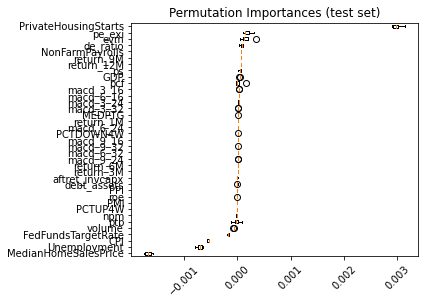

Permutation importance > 0:
['de_ratio', 'evm', 'pe_exi', 'ps', 'pcf', 'aftret_invcapx', 'GDP', 'PrivateHousingStarts', 'NonFarmPayrolls', 'MEDPTG', 'PCTDOWN4W', 'return_1M', 'return_3M', 'return_6M', 'return_9M', 'return_12M', 'macd_3_16', 'macd_3_24', 'macd_3_32', 'macd_6_16', 'macd_6_24', 'macd_6_32', 'macd_9_16', 'macd_9_24', 'macd_9_32']


In [523]:
#permutation importance
clf_importance,clf_features_pi = feature_importance(clf_all, x_test, y_test, features, n_repeats=5, random_state=seed, is_regression = is_regression)

In [524]:
# save model
if is_regression == True:
    label = "FinalModels/NNwithMACDreg_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"
else:
    label = "FinalModels/NNwithMACDclf_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"

clf_all.save(label)
print("Model saved to: " + label)
#loaded_model = tf.keras.models.load_model(label, compile = False)

Model saved to: FinalModels/NNwithMACDclf_37features_8layers_10epochs.h5


In [525]:
#load model
if is_regression == True:
    label = "FinalModels/NNwithMACDreg_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"
else:
    label = "FinalModels/NNwithMACDclf_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"

loaded_model = tf.keras.models.load_model(label, compile = False)

## 2b) Returns-only features

Training Set: 29259, Test Set: 46829



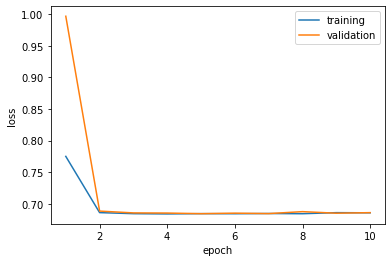

In [526]:
#model params defined in 1d
#reset seed
tf.random.set_seed(seed)

#split data
features = ["return_1M", "return_3M", "return_6M", "return_9M", "return_12M",
           'macd_3_16', 'macd_3_24', 'macd_3_32','macd_6_16', 'macd_6_24', 
            'macd_6_32', 'macd_9_16', 'macd_9_24','macd_9_32']
target = "pred_target"
x_train, y_train, x_test, y_test = get_TrainTest(df_train,df_test,features, target, is_regression = is_regression)

#create model & train
clf_ret = create_NN(hidden, dropout, input_dim = len(features), is_regression = is_regression, std = 0.01, seed = seed)
#print(clf_ret.summary())
clf_ret, history = train_NN(clf_ret, x_train, y_train, x_test, y_test, learning_rate = learning_rate, is_regression = is_regression, num_epochs = num_epochs, plot_graph = True)

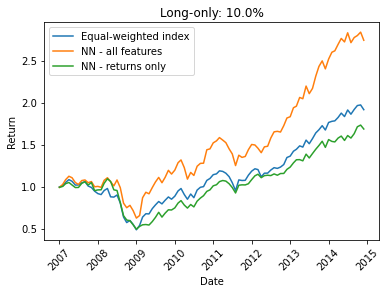

In [527]:
#calculate cost-adjusted returns & plot
#portfolio params defined in 1d
returns_matrix, weight_matrix, rank_table, model_output = get_Matrices(clf_ret, x_test, df_test, is_regression = is_regression, pct = pct, is_short = is_short, company_name = df_train.columns[0])
rets_retonly, cumrets_retonly = calc_returns(returns_matrix, weight_matrix = weight_matrix, k = k)

#calculate return & weight matrix for base strat - i.e. long 100%
returns_matrix_equal, weight_matrix_equal, rank_table_equal, model_output = get_Matrices(clf_ret, x_test, df_test,is_regression = is_regression, pct = 1, is_short = False, company_name = df_train.columns[0])
rets_equal, cumrets_equal = calc_returns(returns_matrix_equal, weight_matrix = weight_matrix_equal, k = k)

plt.plot(cumrets_equal.index, cumrets_equal, label = "Equal-weighted index")
plt.plot(cumrets.index, cumrets, label = "NN - all features")
plt.plot(cumrets_retonly.index, cumrets_retonly, label = "NN - returns only")
plt.legend();
plt.xlabel("Date");
plt.xticks(rotation = 45);
plt.ylabel("Return")
plt.title("Long-only: " + str(pct*100) + "%");

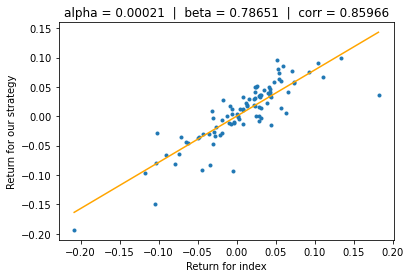

In [528]:
regression_analysis(np.array(rets_equal),np.array(rets_retonly))

In [529]:
#sharpe ratio
print("NN sharpe, all features: ", sharpe)

sharpe_retonly = calc_sharpe(rets_retonly)
print("NN sharpe, returns only: ", sharpe_retonly)
print("Base index sharpe: ", sharpe_equal)

NN sharpe, all features:  0.6243799432588182
NN sharpe, returns only:  0.38190469982911385
Base index sharpe:  0.43753453331199743


In [530]:
#permutation importance
#importance = feature_importance(clf_ret, x_test, y_test, features, n_repeats=5, random_state=seed, is_regression = is_regression)

In [531]:
# save model
if is_regression == True:
    label = "FinalModels/NNwithMACDreg_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"
else:
    label = "FinalModels/NNwithMACDclf_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"

clf_ret.save(label)
print("Model saved to: " + label)
#loaded_model = tf.keras.models.load_model(label, compile = False)

Model saved to: FinalModels/NNwithMACDclf_14features_8layers_10epochs.h5


## 2c) Permutation Importance Features
- Only those with PI above 0
- and return features!

['de_ratio', 'evm', 'pe_exi', 'ps', 'pcf', 'aftret_invcapx', 'GDP', 'PrivateHousingStarts', 'NonFarmPayrolls', 'MEDPTG', 'PCTDOWN4W', 'return_1M', 'return_3M', 'return_6M', 'return_9M', 'return_12M', 'macd_3_16', 'macd_3_24', 'macd_3_32', 'macd_6_16', 'macd_6_24', 'macd_6_32', 'macd_9_16', 'macd_9_24', 'macd_9_32']
Training Set: 29259, Test Set: 46829



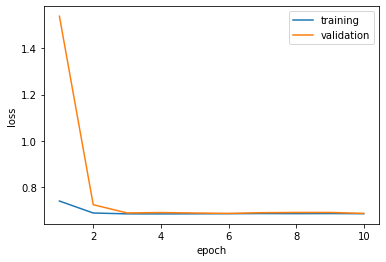

In [532]:
#model params defined in 1d
#reset seed
tf.random.set_seed(seed)

#split data
features = ['npm', 'aftret_invcapx', 'PMI', 'FedFundsTargetRate', 'GDP', 
            'PrivateHousingStarts', 'NonFarmPayrolls', 'Unemployment', 
            'MEDPTG', 'PCTDOWN4W', 'return_1M', 'return_9M', 'return_12M']
#features = ListUnion(features_pi,['return_1M', 'return_9M', 'return_12M'])
#labels = np.array(features)
#clf_features_pi = list(labels[clf_importance.importances_mean > 0])   #refilter
features = clf_features_pi
print(features)
target = "pred_target"
x_train, y_train, x_test, y_test = get_TrainTest(df_train,df_test,features, target, is_regression = is_regression)

#create model & train
clf_pi = create_NN(hidden, dropout, input_dim = len(features), is_regression = is_regression, std = 0.01, seed = seed)
#print(clf_pi.summary())
clf_pi, history = train_NN(clf_pi, x_train, y_train, x_test, y_test, learning_rate = learning_rate, is_regression = is_regression, num_epochs = num_epochs, plot_graph = True)

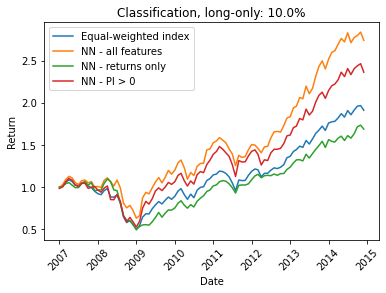

In [533]:
#calculate cost-adjusted returns & plot
#portfolio params defined in 1d
returns_matrix, weight_matrix, rank_table, model_output = get_Matrices(clf_pi, x_test, df_test, is_regression = is_regression, pct = pct, is_short = is_short, company_name = df_train.columns[0])
rets_pi, cumrets_pi = calc_returns(returns_matrix, weight_matrix = weight_matrix, k = k)

#calculate return & weight matrix for base strat - i.e. long 100%
returns_matrix_equal, weight_matrix_equal, rank_table_equal, model_output = get_Matrices(clf_pi, x_test, df_test,is_regression = is_regression, pct = 1, is_short = False, company_name = df_train.columns[0])
rets_equal, cumrets_equal = calc_returns(returns_matrix_equal, weight_matrix = weight_matrix_equal, k = k)

plt.plot(cumrets_equal.index, cumrets_equal, label = "Equal-weighted index")
plt.plot(cumrets.index, cumrets, label = "NN - all features")
plt.plot(cumrets_retonly.index, cumrets_retonly, label = "NN - returns only")
plt.plot(cumrets_pi.index, cumrets_pi, label = "NN - PI > 0")
plt.legend();
plt.xlabel("Date");
plt.xticks(rotation = 45);
plt.ylabel("Return")
if is_regression:
    title = "Regression"
else:
    title = "Classification"
if is_short:
    title = title + ", long-short: " + str(pct*100) + "%"
else:
    title = title + ", long-only: " + str(pct*100) + "%"
plt.title(title);

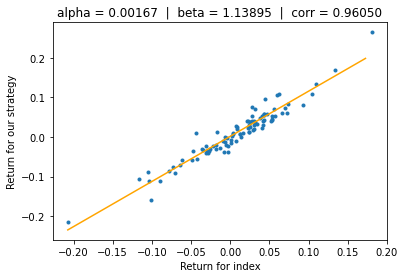

In [534]:
regression_analysis(np.array(rets_equal),np.array(rets_pi))

In [535]:
#sharpe ratio
print("NN sharpe, all features: ", sharpe)
print("NN sharpe, returns only: ", sharpe_retonly)

sharpe_pi = calc_sharpe(rets_pi)
print("NN sharpe, PI > 0: ", sharpe_pi)
print("Base index sharpe: ", sharpe_equal)

NN sharpe, all features:  0.6243799432588182
NN sharpe, returns only:  0.38190469982911385
NN sharpe, PI > 0:  0.49837214714817263
Base index sharpe:  0.43753453331199743


In [536]:
#permutation importance
#importance = feature_importance(clf_pi, x_test, y_test, features, n_repeats=5, random_state=seed, is_regression = is_regression)

In [537]:
# save model
if is_regression == True:
    label = "FinalModels/NNwithMACDreg_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"
else:
    label = "FinalModels/NNwithMACDclf_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"

clf_pi.save(label)
print("Model saved to: " + label)
#loaded_model = tf.keras.models.load_model(label, compile = False)

Model saved to: FinalModels/NNwithMACDclf_25features_8layers_10epochs.h5


# 3) MLP regression

In [538]:
#model params
hidden = [300,300,50]
#dropout = [0.5,0.5,0.3,0.3,0.1]
#hidden = [300,300,300, 200, 200, 100, 100, 50]
dropout = 0.1
is_regression = True
learning_rate = 0.0001
num_epochs = 20

## 3a) All features

Training Set: 29259, Test Set: 46829, Validation Set: 41243 



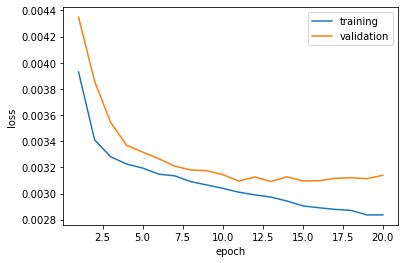

In [539]:
#model params defined in 1d
#reset seed
tf.random.set_seed(seed)

#split data
features = ["debt_assets", "de_ratio", "evm", "pe_exi",
               "roe", "npm","ps", "ptb", "pcf", "aftret_invcapx",
              "CPI", "PMI", "PPI", "FedFundsTargetRate", "GDP", 
              "MedianHomeSalesPrice", "PrivateHousingStarts","NonFarmPayrolls", "Unemployment",
            "MEDPTG", "PCTUP4W", "PCTDOWN4W", "volume",
             "return_1M", "return_3M", "return_6M", "return_9M", "return_12M",
           'macd_3_16', 'macd_3_24', 'macd_3_32','macd_6_16', 'macd_6_24', 
            'macd_6_32', 'macd_9_16', 'macd_9_24','macd_9_32']

target = "pred_target"
x_train, y_train, x_test, y_test, x_validate, y_validate  = get_TrainTestValidate(df_train,df_test,df_validate,features, target, is_regression = is_regression)

#create model & train
reg_all = create_NN(hidden, dropout, input_dim = len(features), is_regression = is_regression, std = 0.01, seed = seed)
#print(reg_all.summary())
reg_all, history = train_NN(reg_all, x_train, y_train, x_test, y_test, learning_rate = learning_rate, is_regression = is_regression, num_epochs = num_epochs, plot_graph = True)

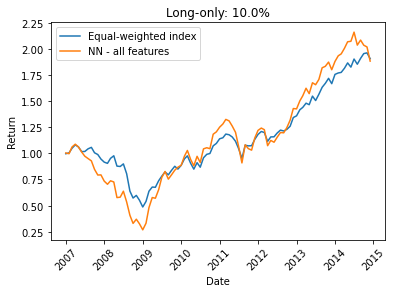

In [540]:
#calculate cost-adjusted returns & plot
#portfolio params defined in 1d
#pct = 0.2
returns_matrix, weight_matrix, rank_table, model_output = get_Matrices(reg_all, x_test, df_test,is_regression = is_regression, pct = pct, is_short = is_short, company_name = df_train.columns[0])
rets, cumrets = calc_returns(returns_matrix, weight_matrix = weight_matrix, k = k)

#calculate return & weight matrix for base strat - i.e. long 100%
returns_matrix_equal, weight_matrix_equal, rank_table_equal, model_output = get_Matrices(reg_all, x_test, df_test,is_regression = is_regression, pct = 1, is_short = False, company_name = df_train.columns[0])
rets_equal, cumrets_equal = calc_returns(returns_matrix_equal, weight_matrix = weight_matrix_equal, k = k)

plt.plot(cumrets_equal.index, cumrets_equal, label = "Equal-weighted index")
plt.plot(cumrets.index, cumrets, label = "NN - all features")
plt.legend();
plt.xlabel("Date");
plt.xticks(rotation = 45);
plt.ylabel("Return")
plt.title("Long-only: " + str(pct*100) + "%");

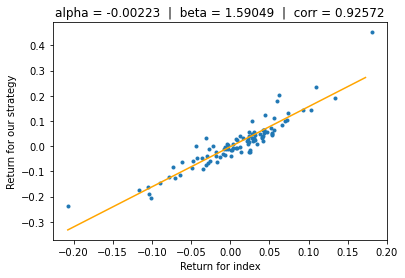

In [541]:
regression_analysis(np.array(rets_equal),np.array(rets))

In [542]:
#sharpe ratio
sharpe = calc_sharpe(rets)
print("NN sharpe: ", sharpe)

sharpe_equal = calc_sharpe(rets_equal)
print("Base index sharpe: ", sharpe_equal)

NN sharpe:  0.25006505111449945
Base index sharpe:  0.43842909878436814


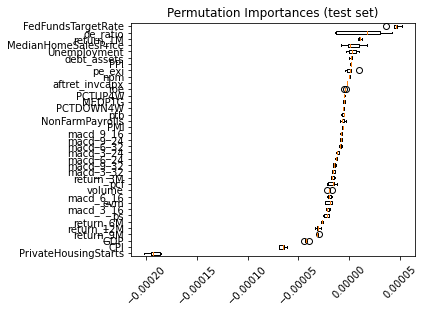

Permutation importance > 0:
['debt_assets', 'de_ratio', 'pe_exi', 'npm', 'PPI', 'FedFundsTargetRate', 'MedianHomeSalesPrice', 'Unemployment', 'return_1M']


In [543]:
#permutation importance
reg_importance,reg_features_pi = feature_importance(reg_all, x_test, y_test, features, n_repeats=5, random_state=seed, is_regression = is_regression)

In [544]:
# save model
if is_regression == True:
    label = "FinalModels/NNwithMACDreg_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"
else:
    label = "FinalModels/NNwithMACDclf_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"

reg_all.save(label)
print("Model saved to: " + label)
#loaded_model = tf.keras.models.load_model(label, compile = False)

Model saved to: FinalModels/NNwithMACDreg_37features_3layers_20epochs.h5


## 3b) Returns-only features

Training Set: 29259, Test Set: 46829



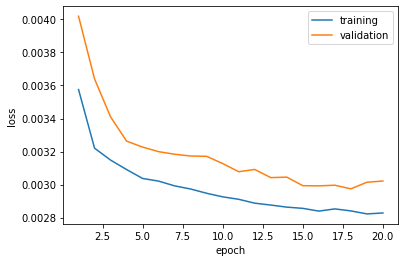

In [545]:
#model params defined in 1d
#reset seed
tf.random.set_seed(seed)

#split data
features = ["return_1M", "return_3M", "return_6M", "return_9M", "return_12M",
           'macd_3_16', 'macd_3_24', 'macd_3_32','macd_6_16', 'macd_6_24', 
            'macd_6_32', 'macd_9_16', 'macd_9_24','macd_9_32']
target = "pred_target"
x_train, y_train, x_test, y_test = get_TrainTest(df_train,df_test,features, target, is_regression = is_regression)

#create model & train
reg_ret = create_NN(hidden, dropout, input_dim = len(features), is_regression = is_regression, std = 0.01, seed = seed)
#print(reg_ret.summary())
reg_ret, history = train_NN(reg_ret, x_train, y_train, x_test, y_test, learning_rate = learning_rate, is_regression = is_regression, num_epochs = num_epochs, plot_graph = True)

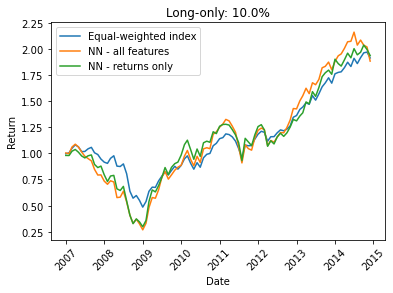

In [546]:
#calculate cost-adjusted returns & plot
#portfolio params defined in 1d
returns_matrix, weight_matrix, rank_table, model_output = get_Matrices(reg_ret, x_test, df_test, is_regression = is_regression, pct = pct, is_short = is_short, company_name = df_train.columns[0])
rets_retonly, cumrets_retonly = calc_returns(returns_matrix, weight_matrix = weight_matrix, k = k)

#calculate return & weight matrix for base strat - i.e. long 100%
returns_matrix_equal, weight_matrix_equal, rank_table_equal, model_output = get_Matrices(reg_ret, x_test, df_test,is_regression = is_regression, pct = 1, is_short = False, company_name = df_train.columns[0])
rets_equal, cumrets_equal = calc_returns(returns_matrix_equal, weight_matrix = weight_matrix_equal, k = k)

plt.plot(cumrets_equal.index, cumrets_equal, label = "Equal-weighted index")
plt.plot(cumrets.index, cumrets, label = "NN - all features")
plt.plot(cumrets_retonly.index, cumrets_retonly, label = "NN - returns only")
plt.legend();
plt.xlabel("Date");
plt.xticks(rotation = 45);
plt.ylabel("Return")
plt.title("Long-only: " + str(pct*100) + "%");

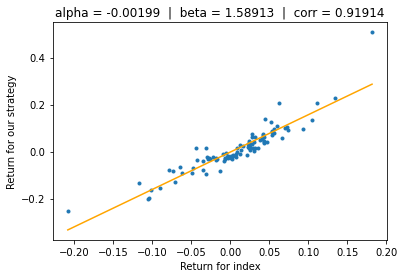

In [547]:
regression_analysis(np.array(rets_equal),np.array(rets_retonly))

In [548]:
#sharpe ratio
print("NN sharpe, all features: ", sharpe)

sharpe_retonly = calc_sharpe(rets_retonly)
print("NN sharpe, returns only: ", sharpe_retonly)
print("Base index sharpe: ", sharpe_equal)

NN sharpe, all features:  0.25006505111449945
NN sharpe, returns only:  0.2587686997952139
Base index sharpe:  0.43842909878436814


In [549]:
#permutation importance
#importance = feature_importance(reg_ret, x_test, y_test, features, n_repeats=5, random_state=seed, is_regression = is_regression)

In [550]:
# save model
if is_regression == True:
    label = "FinalModels/NNwithMACDreg_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"
else:
    label = "FinalModels/NNwithMACDclf_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"

reg_ret.save(label)
print("Model saved to: " + label)
#loaded_model = tf.keras.models.load_model(label, compile = False)

Model saved to: FinalModels/NNwithMACDreg_14features_3layers_20epochs.h5


## 3c) Permutation Importance Features
- Only those with PI above 0
- and return features!

['debt_assets', 'de_ratio', 'pe_exi', 'npm', 'PPI', 'FedFundsTargetRate', 'MedianHomeSalesPrice', 'Unemployment', 'return_1M']
Training Set: 29259, Test Set: 46829



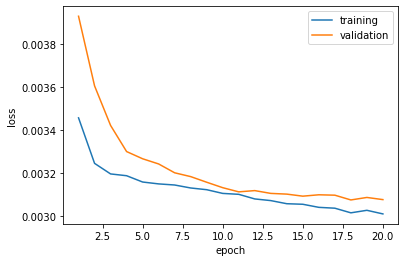

In [551]:
#model params defined in 1d
#reset seed
tf.random.set_seed(seed)

#split data
features = ["debt_assets", "de_ratio", "evm", "pe_exi",
               "roe", "npm","ps", "ptb", "pcf", "aftret_invcapx",
              "CPI", "PMI", "PPI", "FedFundsTargetRate", "GDP", 
              "MedianHomeSalesPrice", "PrivateHousingStarts","NonFarmPayrolls", "Unemployment",
            "MEDPTG", "PCTUP4W", "PCTDOWN4W", "volume",
             "return_1M", "return_3M", "return_6M", "return_9M", "return_12M",
           'macd_3_16', 'macd_3_24', 'macd_3_32','macd_6_16', 'macd_6_24', 
            'macd_6_32', 'macd_9_16', 'macd_9_24','macd_9_32']
labels = np.array(features)
reg_features_pi = list(labels[reg_importance.importances_mean > -0.00000])   #refilter
features = reg_features_pi
print(features)
target = "pred_target"
x_train, y_train, x_test, y_test = get_TrainTest(df_train,df_test,features, target, is_regression = is_regression)

#create model & train
reg_pi = create_NN(hidden, dropout, input_dim = len(features), is_regression = is_regression, std = 0.01, seed = seed)
#print(reg_pi.summary())
reg_pi, history = train_NN(reg_pi, x_train, y_train, x_test, y_test, learning_rate = learning_rate, is_regression = is_regression, num_epochs = num_epochs, plot_graph = True)

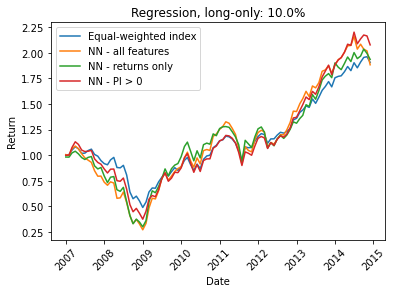

In [552]:
#calculate cost-adjusted returns & plot
#portfolio params defined in 1d
returns_matrix, weight_matrix, rank_table, model_output = get_Matrices(reg_pi, x_test, df_test, is_regression = is_regression, pct = pct, is_short = is_short, company_name = df_train.columns[0])
rets_pi, cumrets_pi = calc_returns(returns_matrix, weight_matrix = weight_matrix, k = k)

#calculate return & weight matrix for base strat - i.e. long 100%
returns_matrix_equal, weight_matrix_equal, rank_table_equal, model_output = get_Matrices(reg_pi, x_test, df_test,is_regression = is_regression, pct = 1, is_short = False, company_name = df_train.columns[0])
rets_equal, cumrets_equal = calc_returns(returns_matrix_equal, weight_matrix = weight_matrix_equal, k = k)

plt.plot(cumrets_equal.index, cumrets_equal, label = "Equal-weighted index")
plt.plot(cumrets.index, cumrets, label = "NN - all features")
plt.plot(cumrets_retonly.index, cumrets_retonly, label = "NN - returns only")
plt.plot(cumrets_pi.index, cumrets_pi, label = "NN - PI > 0")
plt.legend();
plt.xlabel("Date");
plt.xticks(rotation = 45);
plt.ylabel("Return")
if is_regression:
    title = "Regression"
else:
    title = "Classification"
if is_short:
    title = title + ", long-short: " + str(pct*100) + "%"
else:
    title = title + ", long-only: " + str(pct*100) + "%"
plt.title(title);

In [553]:
#save rankings
model_output = reg_pi.predict(x_test)
if is_regression == False or is_regression == "brier":
    model_output = model_output[:,1]
#map to original test dataframe for price data
predictions = df_test.iloc[:,:5]
predictions["pred"] = model_output

#rank predictions
predictions["rank"] = predictions.groupby("month")["pred"].rank("dense", ascending = False)
pred_table = pd.pivot_table(predictions, values="pred", index=["month"],
                columns=[df_test.columns[0]])
rank_table = pd.pivot_table(predictions, values="rank", index=["month"],
                columns=[df_test.columns[0]])

rank_table.to_csv("Rankings/NNwithMACD_Regression_ranks.csv")
pred_table.to_csv("Rankings/NNwithMACD_Regression_modeloutputs.csv")

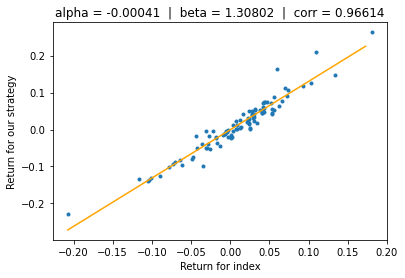

In [554]:
regression_analysis(np.array(rets_equal),np.array(rets_pi))

In [555]:
#sharpe ratio
print("NN sharpe, all features: ", sharpe)
print("NN sharpe, returns only: ", sharpe_retonly)

sharpe_pi = calc_sharpe(rets_pi)
print("NN sharpe, PI > 0: ", sharpe_pi)
print("Base index sharpe: ", sharpe_equal)

NN sharpe, all features:  0.25006505111449945
NN sharpe, returns only:  0.2587686997952139
NN sharpe, PI > 0:  0.3689639458538748
Base index sharpe:  0.43842909878436814


In [556]:
#permutation importance
#importance = feature_importance(reg_pi, x_test, y_test, features, n_repeats=5, random_state=seed, is_regression = is_regression)

In [557]:
# save model
if is_regression == True:
    label = "FinalModels/NNwithMACDreg_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"
else:
    label = "FinalModels/NNwithMACDclf_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"

reg_pi.save(label)
print("Model saved to: " + label)
#loaded_model = tf.keras.models.load_model(label, compile = False)

Model saved to: FinalModels/NNwithMACDreg_9features_3layers_20epochs.h5


# 4) Tune models & validate

## 4a) Hyperparameter tuning sklearn

In [44]:
features = ["debt_assets", "de_ratio", "evm", "pe_exi",
               "roe", "npm","ps", "ptb", "pcf", "aftret_invcapx",
              "CPI", "PMI", "PPI", "FedFundsTargetRate", "GDP", 
              "MedianHomeSalesPrice", "PrivateHousingStarts","NonFarmPayrolls", "Unemployment",
            "MEDPTG", "PCTUP4W", "PCTDOWN4W", "volume",
             "return_1M", "return_3M", "return_6M", "return_9M", "return_12M"]

x_train, y_train, x_test, y_test = get_TrainTest(df_train,df_test,features, target, is_regression = is_regression)

search_model = KerasClassifier(build_fn = create_NN)
param_grid = dict(epochs = [5,10,20,30], 
                  hidden = [[300,300,300, 200, 200, 100, 100, 50],
                            [300, 200, 200, 100, 100, 50],
                            [200, 100, 100, 50],
                            [100, 50]],
                  dropout = [0, 0.1,0.2,0.3,0.4,0.5],
                  learning_rate = [1, 0.1,0.01, 0.01, 0.001,0.0001],
                  is_search = [True], is_regression = [True,False, "brier"], input_dim = len(features))
search = GridSearchCV(estimator = search_model, param_grid = param_grid, cv = 3)
search = search.fit(x_train, y_train)

best_params=search.best_params_
accuracy=search.best_score_



done


In [ ]:
#fast test

features = ["debt_assets", "de_ratio", "evm", "pe_exi",
               "roe", "npm","ps", "ptb", "pcf", "aftret_invcapx",
              "CPI", "PMI", "PPI", "FedFundsTargetRate", "GDP", 
              "MedianHomeSalesPrice", "PrivateHousingStarts","NonFarmPayrolls", "Unemployment",
            "MEDPTG", "PCTUP4W", "PCTDOWN4W", "volume",
             "return_1M", "return_3M", "return_6M", "return_9M", "return_12M"]

x_train, y_train, x_test, y_test = get_TrainTest(df_train,df_test,features, target, is_regression = is_regression)

search_model = KerasClassifier(build_fn = create_NN)
param_grid = dict(epochs = [5,10], 
                  hidden = [[200, 100, 100, 50],
                            [100, 50]],
                  dropout = [0, 0.1],
                  learning_rate = [0.1,0.01],
                  is_search = [True], is_regression = [False], is_brier = [True,False],input_dim = [len(features)])
search = GridSearchCV(estimator = search_model, param_grid = param_grid, cv = 3)
search = search.fit(x_train, y_train, verbose = 0)

best_params=search.best_params_
accuracy=search.best_score_



In [101]:
print("params:",search.best_params_)
print("metric:",search.best_score_)

params: {'dropout': 0.1, 'epochs': 10, 'hidden': [100, 50], 'input_dim': 28, 'is_regression': False, 'is_search': True, 'learning_rate': 0.01}
metric: 0.5588316520055135


## 4b) Hyperparameter tuning Hyperopt

## 4b) Best Test Models

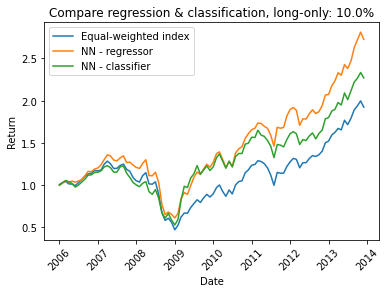

In [174]:
#calculate cost-adjusted returns & plot
is_short = False
k = 5
#portfolio params defined in 1d
returns_matrix_reg, weight_matrix_reg, rank_table_reg, model_output_reg = get_Matrices(reg_all, x_test, df_test, is_regression = True, pct = pct, is_short = is_short, company_name = df_train.columns[0])
rets_reg, cumrets_reg = calc_returns(returns_matrix_reg, weight_matrix = weight_matrix_reg, k = k)

#calculate return & weight matrix for classifier
returns_matrix_clf, weight_matrix_clf, rank_table_clf, model_output_clf = get_Matrices(clf_all, x_test, df_test,is_regression = False, pct = pct, is_short = is_short, company_name = df_train.columns[0])
rets_clf, cumrets_clf = calc_returns(returns_matrix_clf, weight_matrix = weight_matrix_clf, k = k)

#calculate return & weight matrix for base strat - i.e. long 100%
returns_matrix_equal, weight_matrix_equal, rank_table_equal, model_output = get_Matrices(clf_all, x_test, df_test,is_regression = False, pct = 1, is_short = False, company_name = df_train.columns[0])
rets_equal, cumrets_equal = calc_returns(returns_matrix_equal, weight_matrix = weight_matrix_equal, k = k)

plt.plot(cumrets_equal.index, cumrets_equal, label = "Equal-weighted index")
plt.plot(cumrets_reg.index, cumrets_reg, label = "NN - regressor")
plt.plot(cumrets_clf.index, cumrets_clf, label = "NN - classifier")
plt.legend();
plt.xlabel("Date");
plt.xticks(rotation = 45);
plt.ylabel("Return")

title = "Compare regression & classification"
if is_short:
    title = title + ", long-short: " + str(pct*100) + "%"
else:
    title = title + ", long-only: " + str(pct*100) + "%"
plt.title(title);

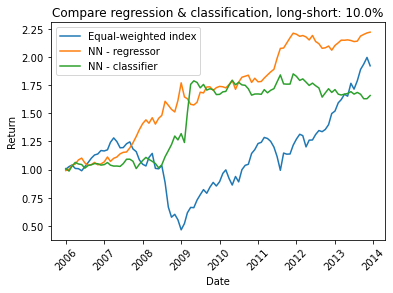

In [175]:
#calculate cost-adjusted returns & plot
is_short = True
k = 5
#portfolio params defined in 1d
returns_matrix_reg, weight_matrix_reg, rank_table_reg, model_output_reg = get_Matrices(reg_all, x_test, df_test, is_regression = True, pct = pct, is_short = is_short, company_name = df_train.columns[0])
rets_reg, cumrets_reg = calc_returns(returns_matrix_reg, weight_matrix = weight_matrix_reg, k = k)

#calculate return & weight matrix for classifier
returns_matrix_clf, weight_matrix_clf, rank_table_clf, model_output_clf = get_Matrices(clf_all, x_test, df_test,is_regression = False, pct = pct, is_short = is_short, company_name = df_train.columns[0])
rets_clf, cumrets_clf = calc_returns(returns_matrix_clf, weight_matrix = weight_matrix_clf, k = k)

#calculate return & weight matrix for base strat - i.e. long 100%
returns_matrix_equal, weight_matrix_equal, rank_table_equal, model_output = get_Matrices(clf_all, x_test, df_test,is_regression = False, pct = 1, is_short = False, company_name = df_train.columns[0])
rets_equal, cumrets_equal = calc_returns(returns_matrix_equal, weight_matrix = weight_matrix_equal, k = k)

plt.plot(cumrets_equal.index, cumrets_equal, label = "Equal-weighted index")
plt.plot(cumrets_reg.index, cumrets_reg, label = "NN - regressor")
plt.plot(cumrets_clf.index, cumrets_clf, label = "NN - classifier")
plt.legend();
plt.xlabel("Date");
plt.xticks(rotation = 45);
plt.ylabel("Return")

title = "Compare regression & classification"
if is_short:
    title = title + ", long-short: " + str(pct*100) + "%"
else:
    title = title + ", long-only: " + str(pct*100) + "%"
plt.title(title);

## 4c) Validation

In [84]:
df_train = df_nn[(df_nn["month"]>= "2002-01") & (df_nn["month"]<= "2014-12")].reset_index(drop = True)
df_test = df_nn[(df_nn["month"]>= "2015-01") & (df_nn["month"]<= "2021-12")].reset_index(drop = True)
print("done")

done


Training Set: 76088, Test Set: 41243, Validation Set: 41243 



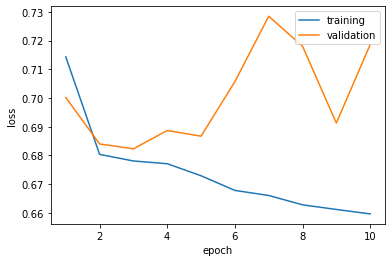

In [85]:
#model params
#hidden = [300,300,50]
#dropout = 0.3
hidden = [300,300,300, 200, 200, 100, 100, 50]
dropout = 0.1
is_regression = False
learning_rate = 0.1
num_epochs = 10

#model params defined in 1d
#reset seed
tf.random.set_seed(seed)

#split data
features = ["debt_assets", "de_ratio", "evm", "pe_exi",
               "roe", "npm","ps", "ptb", "pcf", "aftret_invcapx",
              "CPI", "PMI", "PPI", "FedFundsTargetRate", "GDP", 
              "MedianHomeSalesPrice", "PrivateHousingStarts","NonFarmPayrolls", "Unemployment",
            "MEDPTG", "PCTUP4W", "PCTDOWN4W", "volume",
             "return_1M", "return_3M", "return_6M", "return_9M", "return_12M",
            'macd_3_16', 'macd_3_24', 'macd_3_32','macd_6_16', 'macd_6_24', 
            'macd_6_32', 'macd_9_16', 'macd_9_24','macd_9_32']
target = "pred_target"
x_train, y_train, x_test, y_test, x_validate, y_validate  = get_TrainTestValidate(df_train,df_test,df_validate,features, target, is_regression = is_regression)

#create model & train
clf_all = create_NN(hidden, dropout, input_dim = len(features), is_regression = is_regression, std = 0.01, seed = seed)
#print(clf_all.summary())
clf_all, history = train_NN(clf_all, x_train, y_train, x_test, y_test, learning_rate = learning_rate, is_regression = is_regression, num_epochs = num_epochs, plot_graph = True)

Training Set: 76088, Test Set: 41243, Validation Set: 41243 



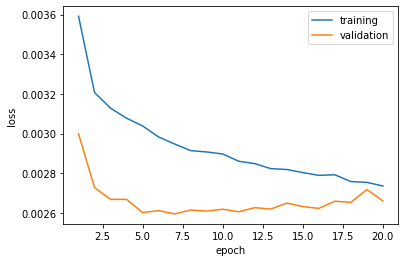

In [86]:
#model params
hidden = [300,300,50]
#dropout = [0.5,0.5,0.3,0.3,0.1]
#hidden = [300,300,300, 200, 200, 100, 100, 50]
dropout = 0.1
is_regression = True
learning_rate = 0.0001
num_epochs = 20

#model params defined in 1d
#reset seed
tf.random.set_seed(seed)

#split data
features = ["debt_assets", "de_ratio", "evm", "pe_exi",
               "roe", "npm","ps", "ptb", "pcf", "aftret_invcapx",
              "CPI", "PMI", "PPI", "FedFundsTargetRate", "GDP", 
              "MedianHomeSalesPrice", "PrivateHousingStarts","NonFarmPayrolls", "Unemployment",
            "MEDPTG", "PCTUP4W", "PCTDOWN4W", "volume",
             "return_1M", "return_3M", "return_6M", "return_9M", "return_12M",
           'macd_3_16', 'macd_3_24', 'macd_3_32','macd_6_16', 'macd_6_24', 
            'macd_6_32', 'macd_9_16', 'macd_9_24','macd_9_32']
target = "pred_target"
x_train, y_train, x_test, y_test, x_validate, y_validate  = get_TrainTestValidate(df_train,df_test,df_validate,features, target, is_regression = is_regression)

#create model & train
reg_all = create_NN(hidden, dropout, input_dim = len(features), is_regression = is_regression, std = 0.01, seed = seed)
#print(reg_all.summary())
reg_all, history = train_NN(reg_all, x_train, y_train, x_test, y_test, learning_rate = learning_rate, is_regression = is_regression, num_epochs = num_epochs, plot_graph = True)

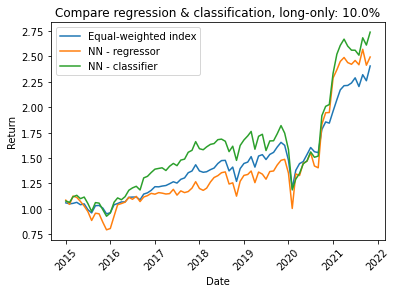

In [87]:
#validation
#calculate cost-adjusted returns & plot
is_short = False
pct = 0.1
k = 5

#portfolio params defined in 1d
returns_matrix_reg, weight_matrix_reg, rank_table_reg, model_output_reg = get_Matrices(reg_all, x_test, df_test, is_regression = True, pct = pct, is_short = is_short, company_name = df_train.columns[0])
rets_reg, cumrets_reg = calc_returns(returns_matrix_reg, weight_matrix = weight_matrix_reg, k = k)

#calculate return & weight matrix for classifier
returns_matrix_clf, weight_matrix_clf, rank_table_clf, model_output_clf = get_Matrices(clf_all, x_test, df_test,is_regression = False, pct = pct, is_short = is_short, company_name = df_train.columns[0])
rets_clf, cumrets_clf = calc_returns(returns_matrix_clf, weight_matrix = weight_matrix_clf, k = k)

#calculate return & weight matrix for base strat - i.e. long 100%
returns_matrix_equal, weight_matrix_equal, rank_table_equal, model_output = get_Matrices(clf_all, x_test, df_test,is_regression = False, pct = 1, is_short = False, company_name = df_train.columns[0])
rets_equal, cumrets_equal = calc_returns(returns_matrix_equal, weight_matrix = weight_matrix_equal, k = k)

plt.plot(cumrets_equal.index, cumrets_equal, label = "Equal-weighted index")
plt.plot(cumrets_reg.index, cumrets_reg, label = "NN - regressor")
plt.plot(cumrets_clf.index, cumrets_clf, label = "NN - classifier")
plt.legend();
plt.xlabel("Date");
plt.xticks(rotation = 45);
plt.ylabel("Return")

title = "Compare regression & classification"
if is_short:
    title = title + ", long-short: " + str(pct*100) + "%"
else:
    title = title + ", long-only: " + str(pct*100) + "%"
plt.title(title);

In [88]:
print(calc_sharpe(rets_equal))
print(calc_sharpe(rets_clf))
print(calc_sharpe(rets_reg))

print()

print(calc_mdd(rets_equal))
print(calc_mdd(rets_clf))
print(calc_mdd(rets_reg))

0.8220207036801894
0.7248624015937204
0.5223199642003178

(0.27376072736220025, 61)
(0.34826433495764364, 61)
(0.3252536118370012, 61)


In [591]:
msp500_unique = pd.read_pickle("FinalMembers/linktable.pkl")
investments = weight_matrix_reg.sum(axis = 0).sort_values(ascending = False)
investments = pd.DataFrame(investments).merge(msp500_unique, left_index= True, right_on = "PERMNO", how = "left")
investments.rename(columns={0:"total_weight"}, inplace=True)
investments = investments.drop_duplicates(["PERMNO"])
investments

,total_weight,PERMNO,start,ending,NAMEDT,NAMEENDT,CUSIP,TICKER
332,1.300816,12622,2015-01-27,2021-12-31,2011-03-10,2015-04-12,40412C10,HCA
837,1.217551,18729,1957-03-01,2021-12-31,1998-09-01,2002-01-01,19416210,CL
1755,1.139184,39917,1963-12-05,2021-12-31,1968-01-02,2001-02-28,96216610,WY
741,1.118367,17750,1957-03-01,2021-12-31,1968-01-02,2001-08-23,49436810,KMB
1604,1.115510,34032,1981-06-18,2021-12-31,1969-05-05,2002-01-01,57459910,MAS
...,...,...,...,...,...,...,...,...
2532,0.000000,60506,1980-10-02,2021-12-31,1982-11-01,2004-06-09,69371810,PCAR
2528,0.000000,60442,1988-04-14,2021-12-31,1993-02-09,2000-03-14,69347510,PNC
2518,0.000000,60206,1982-09-16,2021-12-31,1994-05-09,2002-01-01,83303410,SNA
2509,0.000000,60097,1986-10-23,2021-12-31,1999-01-04,2002-01-01,G5960L10,MDT


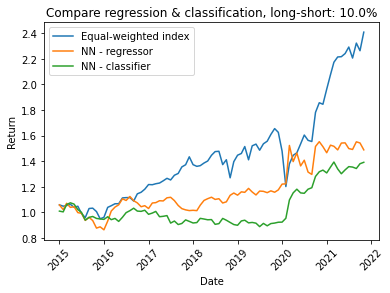

In [592]:
#validation
#calculate cost-adjusted returns & plot
is_short = True
pct = 0.1
k = 5
#portfolio params defined in 1d
returns_matrix_reg, weight_matrix_reg, rank_table_reg, model_output_reg = get_Matrices(reg_all, x_test, df_test, is_regression = True, pct = pct, is_short = is_short, company_name = df_train.columns[0])
rets_reg, cumrets_reg = calc_returns(returns_matrix_reg, weight_matrix = weight_matrix_reg, k = k)

#calculate return & weight matrix for classifier
returns_matrix_clf, weight_matrix_clf, rank_table_clf, model_output_clf = get_Matrices(clf_all, x_test, df_test,is_regression = False, pct = pct, is_short = is_short, company_name = df_train.columns[0])
rets_clf, cumrets_clf = calc_returns(returns_matrix_clf, weight_matrix = weight_matrix_clf, k = k)

#calculate return & weight matrix for base strat - i.e. long 100%
returns_matrix_equal, weight_matrix_equal, rank_table_equal, model_output = get_Matrices(clf_all, x_test, df_test,is_regression = False, pct = 1, is_short = False, company_name = df_train.columns[0])
rets_equal, cumrets_equal = calc_returns(returns_matrix_equal, weight_matrix = weight_matrix_equal, k = k)

plt.plot(cumrets_equal.index, cumrets_equal, label = "Equal-weighted index")
plt.plot(cumrets_reg.index, cumrets_reg, label = "NN - regressor")
plt.plot(cumrets_clf.index, cumrets_clf, label = "NN - classifier")
plt.legend();
plt.xlabel("Date");
plt.xticks(rotation = 45);
plt.ylabel("Return")

title = "Compare regression & classification"
if is_short:
    title = title + ", long-short: " + str(pct*100) + "%"
else:
    title = title + ", long-only: " + str(pct*100) + "%"
plt.title(title);

# 5) Pairwise LTR - RankNet
- queries = dates
- documents = valid tickers, the features of which are xi
- scores = future 1M returns, si

Target probabilities:

- Pij = 1 if si > sj, 0.5 if si = sj, 0 if si < sj

Predicted probabilities
- Oij = f(xi) - f(xj)
- Squeeze through logistic function
- Qij = 1-Qji = exp(Oij) / (1 + exp(Oij)

Use cross-entropy loss.

In [70]:
#model params
#hidden = [300,300,150,150,50]
#dropout = [0.5,0.5,0.3,0.3,0.1]
#hidden = [300,300,300, 200, 200, 100, 100, 50]
#dropout = [0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]
hidden = [300,300, 50]
dropout = [0.1,0.1,0.1]
is_regression = True
is_ltr = True
learning_rate = 0.001
num_epochs = 10
seed = 1

## 5a) Build model

In [25]:
# model architecture
class RankNet(Model):
    def __init__(self, hidden_layers, dropout_layers, stddev = 0.01, seed = 1):
        super().__init__()
        #input + hidden layers
        self.dense = [layers.Dense(hidden_layers[i], activation='relu',kernel_initializer=initializers.RandomNormal(stddev=stddev, seed = seed)) for i in range(len(hidden_layers))]
        self.dropout = [Dropout(dropout_layers[i], seed = seed) for i in range(len(dropout_layers))]
        #output layer
        self.o = layers.Dense(1, activation='linear')
        #subtract outputs
        self.oi_minus_oj = layers.Subtract()
    
    def call(self, inputs):
        xi, xj = inputs
        #input layer
        densei = self.dense[0](xi)
        densej = self.dense[0](xj)
        #hidden layers
        for dense, dropout in zip(self.dense[1:],self.dropout[1:]):
            densei = dense(densei)
            densej = dense(densej)
            #dropout
            densei = dropout(densei)
            densej = dropout(densej)
        #output layer
        oi = self.o(densei)
        oj= self.o(densej)
        #subtraction layer
        oij = self.oi_minus_oj([oi, oj])
        #apply sigmoid to output
        output = layers.Activation('sigmoid')(oij)
        return output
    
    def build_graph(self):
        x = [Input(shape=(5)), Input(shape=(5))]
        return Model(inputs=x, outputs=self.call(x))


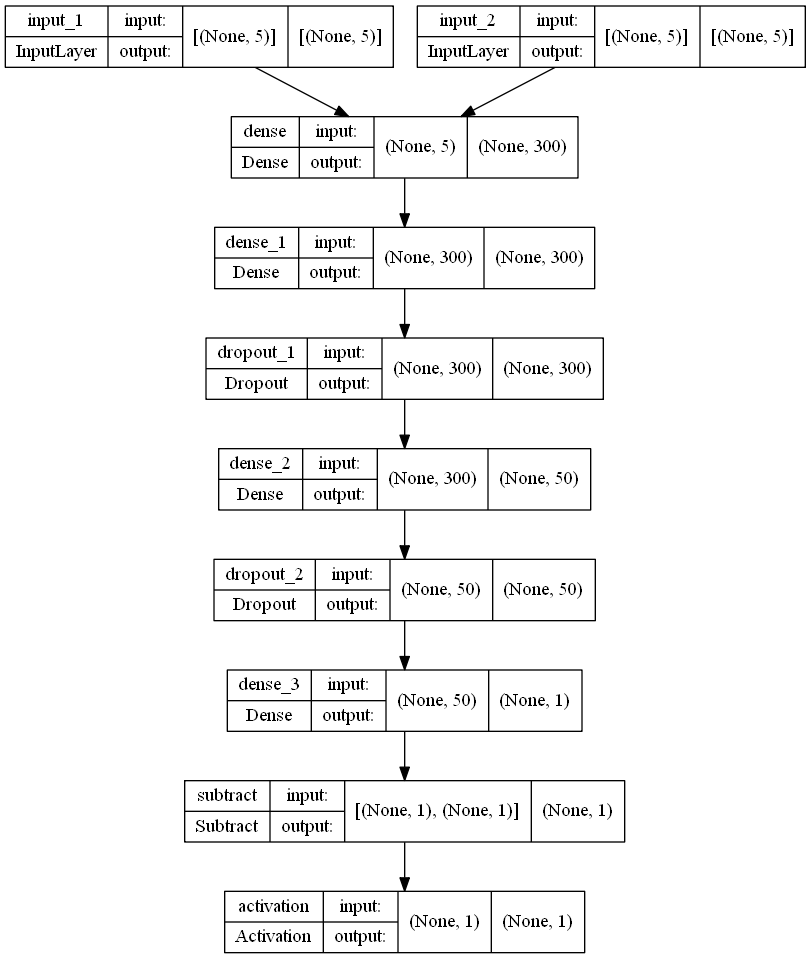

In [26]:
# visualize model architecture
plot_model(RankNet(hidden,dropout, stddev = 0.01, seed = seed).build_graph(), show_shapes=True)

## 5b) Process data
- We need to create pairs of inputs 
  - 2 each of x_train, x_test; 
  - 1 each of y_train, y_test; 
  - 1 each of pair_id_train, pair_id_test to match pairs of inputs
  
- need more efficient method for creating the pairs.
    - separate validation set by query id
    from sklearn.model_selection import GroupShuffleSplit
    gss = GroupShuffleSplit(test_size=.40, n_splits=1, random_state = 7).split(df, groups=df['id'])
    https://medium.com/predictly-on-tech/learning-to-rank-using-xgboost-83de0166229d

- need to edit this so pair_query_id contains the stock identifier

In [27]:
df_train = df_nn[(df_nn["month"]>= "2002-01") & (df_nn["month"]<= "2006-12")].reset_index(drop = True)
df_test = df_nn[(df_nn["month"]>= "2007-01") & (df_nn["month"]<= "2014-12")].reset_index(drop = True)
df_validate = df_nn[(df_nn["month"]>= "2015-01") & (df_nn["month"]<= "2021-12")].reset_index(drop = True)
print("done")

done


In [28]:
#model params defined in 1d
#reset seed
tf.random.set_seed(seed)


#split data
features = ["debt_assets", "de_ratio", "evm", "pe_exi",
               "roe", "npm","ps", "ptb", "pcf", "aftret_invcapx",
              "CPI", "PMI", "PPI", "FedFundsTargetRate", "GDP", 
              "MedianHomeSalesPrice", "PrivateHousingStarts","NonFarmPayrolls", "Unemployment",
            "MEDPTG", "PCTUP4W", "PCTDOWN4W", "volume",
             "return_1M", "return_3M", "return_6M", "return_9M", "return_12M"]
target = "pred_target"
x_train, y_train,q_train,x_test,y_test,q_test,x_validate,y_validate,q_validate= get_TrainTestValidate(df_train,df_test,df_validate,features, target, is_regression = is_regression, is_ltr = is_ltr)


Training Set: 29259, Test Set: 46829, Validation Set: 41243 



In [29]:
#format train set

tic = time()
xi_train, xj_train, pij_train, pair_train, query_train = create_pairs(
                query = q_train, doc_features = x_train, doc_scores = y_train)
toc = time()
print("training set:", toc - tic, "secs")
print(np.shape(xi_train))

np.save("PairwiseLTRwithMACD/xi_train.npy",xi_train)
np.save("PairwiseLTRwithMACD/xj_train.npy",xj_train)
np.save("PairwiseLTRwithMACD/pij_train.npy",pij_train)
np.save("PairwiseLTRwithMACD/pair_train.npy",pair_train)
np.save("PairwiseLTRwithMACD/query_train.npy",query_train)
print("done")


training set: 17.516051292419434 secs
(7119599, 28)
done


In [30]:
#format test set

tic = time()   
xi_test, xj_test, pij_test, pair_test, query_test = create_pairs(
                query = q_test, doc_features = x_test, doc_scores = y_test)
toc = time()
print("training set:", toc - tic, "secs")
print(np.shape(xi_test))

np.save("PairwiseLTRwithMACD/xi_test.npy",xi_test)
np.save("PairwiseLTRwithMACD/xj_test.npy",xj_test)
np.save("PairwiseLTRwithMACD/pij_test.npy",pij_test)
np.save("PairwiseLTRwithMACD/pair_test.npy",pair_test)
np.save("PairwiseLTRwithMACD/query_test.npy",query_test)
print("done")


training set: 31.857665538787842 secs
(11398663, 28)
done


In [31]:
#format validation set

tic = time()   
xi_validate, xj_validate, pij_validate, pair_validate, query_validate = create_pairs(
                query = q_validate, doc_features = x_validate, doc_scores = y_validate)
toc = time()
print("validation set:", toc - tic, "secs")
print(np.shape(xi_validate))

np.save("PairwiseLTRwithMACD/xi_validate.npy",xi_validate)
np.save("PairwiseLTRwithMACD/xj_validate.npy",xj_validate)
np.save("PairwiseLTRwithMACD/pij_validate.npy",pij_validate)
np.save("PairwiseLTRwithMACD/pair_validate.npy",pair_validate)
np.save("PairwiseLTRwithMACD/query_validate.npy",query_validate)
print("done")


validation set: 29.203221321105957 secs
(10226628, 28)
done


In [32]:
#load training set
xi_train= np.load("PairwiseLTRwithMACD/xi_train.npy")
xj_train= np.load("PairwiseLTRwithMACD/xj_train.npy")
pij_train = np.load("PairwiseLTRwithMACD/pij_train.npy")
pair_train = np.load("PairwiseLTRwithMACD/pair_train.npy")
query_train = np.load("PairwiseLTRwithMACD/query_train.npy", allow_pickle = True)

#load test set
xi_test= np.load("PairwiseLTRwithMACD/xi_test.npy")
xj_test= np.load("PairwiseLTRwithMACD/xj_test.npy")
pij_test = np.load("PairwiseLTRwithMACD/pij_test.npy")
pair_test = np.load("PairwiseLTRwithMACD/pair_test.npy")
query_test = np.load("PairwiseLTRwithMACD/query_test.npy", allow_pickle = True)

#load validation set
xi_validate= np.load("PairwiseLTRwithMACD/xi_validate.npy")
xj_validate= np.load("PairwiseLTRwithMACD/xj_validate.npy")
pij_validate = np.load("PairwiseLTRwithMACD/pij_validate.npy")
pair_validate = np.load("PairwiseLTRwithMACD/pair_validate.npy")
query_validate = np.load("PairwiseLTRwithMACD/query_validate.npy", allow_pickle = True)

print("Train:", np.shape(xi_train),"Test:", np.shape(xi_test),"Validation:", np.shape(xi_validate))

print("done")

Train: (7119599, 28) Test: (11398663, 28) Validation: (10226628, 28)
done


## 5c) Train RankNet

In [99]:
# train model using compile and fit
#learning_rate = 1e-6
learning_rate = 0.1
hidden = [300,300,50]
dropout = [0.1,0.1,0.1]
ranknet = RankNet(hidden,dropout,stddev = 0.01,seed=seed)
opt = optimizers.Adam(learning_rate=learning_rate)
ranknet.compile(optimizer=opt, loss='binary_crossentropy')
#ranknet.compile(optimizer=opt, loss=custom_brier)
history = ranknet.fit([xi_train, xj_train], pij_train, epochs=1, batch_size=1500, validation_data=([xi_test, xj_test], pij_test))

4747/4747 [==============================] - 157s 33ms/step - loss: 0.8466 - val_loss: 0.6931


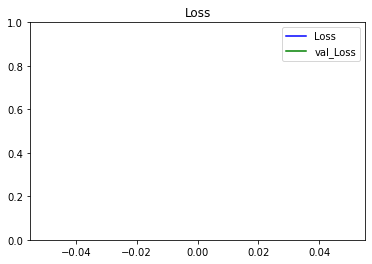

In [100]:
# function for plotting loss
def plot_metrics(train_metric, val_metric=None, metric_name=None, title=None, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(train_metric,color='blue',label=metric_name)
    if val_metric is not None: plt.plot(val_metric,color='green',label='val_' + metric_name)
    plt.legend(loc="upper right")

# plot loss history
plot_metrics(history.history['loss'], history.history['val_loss'], "Loss", "Loss", ylim=1.0)

In [101]:
# save model
if is_regression == True:
    label = "FinalModels/NNwithMACDreg_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"
if is_ltr == True:
    label = "FinalModels/PairwiseLTRwithMACD.tf"
else:
    label = "FinalModels/NNwithMACDclf_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"

ranknet.save(label)
print("Model saved to: " + label)
#loaded_model = tf.keras.models.load_model(label, compile = False)

INFO:tensorflow:Assets written to: FinalModels/PairwiseLTRwithMACD.tf\assets
Model saved to: FinalModels/PairwiseLTRwithMACD.tf


## 5d) Evaluate strategy
Two methods to convert pairs into rankings
- Bradley Terry and Elo models: convert sign(pred-0.5) into {-1, 1}
- simply sum all predictions {0 to 1} for each stock in a given month ==> current approach

In [102]:
#make predictions
tic = time()
#n_outputs = 1000000
n_outputs = len(xi_test)
print(n_outputs)
model_output = ranknet.predict([xi_test[:n_outputs], xj_test[:n_outputs]])
toc = time()
print("make predictions:", toc - tic, "secs")

11398663
make predictions: 282.30217933654785 secs


In [103]:
model_output

array([[0.5],
       [0.5],
       [0.5],
       ...,
       [0.5],
       [0.5],
       [0.5]], dtype=float32)

C:\Users\pyliu\AppData\Local\Temp/ipykernel_169408/662977103.py:25: RuntimeWarning: divide by zero encountered in true_divide
  weight_matrix[rank_table.lt(np.floor(pct*rank_table.max(axis = 1))+1, axis = 0)] = 1/np.transpose(np.tile(np.floor(rank_table.max(axis = 1)*pct),(len(rank_table.columns),1)))


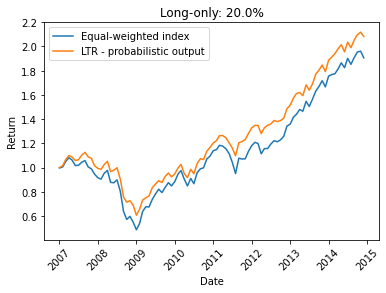

In [66]:
#calc returns
k = 5
pct = 0.2
is_short = False
discretise = False
returns_matrix1, weight_matrix1, rank_table1, _1 = get_Matrices_LTR(
                    model_output, df_test, company_name = "PERMNO", pct = pct, is_short = is_short, max_ret = 10, discretise = False)
returns_matrix2, weight_matrix2, rank_table2, _2 = get_Matrices_LTR(
                    model_output, df_test, company_name = "PERMNO", pct = pct, is_short = is_short, max_ret = 10, discretise = True)
rets1, cumrets1 = calc_returns(returns_matrix1, weight_matrix = weight_matrix1, k = k)
rets2, cumrets2 = calc_returns(returns_matrix2, weight_matrix = weight_matrix2, k = k)

#plt.plot(cumrets_equal.index, cumrets_equal, label = "Equal-weighted index")
plt.plot(cumrets1.index, cumrets1, label = "LTR - probabilistic output")
#plt.plot(cumrets2.index, cumrets2, label = "LTR - discretised output")
plt.legend();
plt.xlabel("Date");
plt.xticks(rotation = 45);
plt.ylabel("Return")
plt.title("Long-only: " + str(pct*100) + "%");

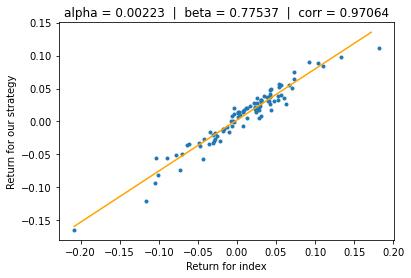

In [67]:
regression_analysis(np.array(rets_equal),np.array(rets1))

In [68]:
#sharpe ratio
sharpe = calc_sharpe(rets1)
print("LTR probabilistic sharpe: ", sharpe)
mdd = calc_mdd(rets1)
print("LTR probabilistic mdd: ", mdd[0])
"""
sharpe = calc_sharpe(rets2)
print("LTR discretised sharpe: ", sharpe)
mdd = calc_mdd(rets2)
print("LTR discretised mdd: ", mdd[0])
"""
sharpe_equal = calc_sharpe(rets_equal)
print("Base index sharpe: ", sharpe_equal)
mdd_equal = calc_mdd(rets_equal)
print("Base index mdd: ", mdd_equal[0])

LTR probabilistic sharpe:  0.6262855627686953
LTR probabilistic mdd:  0.4615202082007832
Base index sharpe:  0.43753453331199743
Base index mdd:  0.5509856755191946


## 5d) Validate RankNet

In [73]:
# train model using compile and fit
#learning_rate = 1e-6
learning_rate = 0.1
hidden = [300,300,50]
dropout = [0.1,0.1,0.1]
ranknet = RankNet(hidden,dropout,stddev = 0.01,seed=seed)
opt = optimizers.Adam(learning_rate=learning_rate)
ranknet.compile(optimizer=opt, loss='binary_crossentropy')
#ranknet.compile(optimizer=opt, loss=custom_brier)
history = ranknet.fit([xi_test, xj_test], pij_test, epochs=1, batch_size=1500, validation_data=([xi_validate, xj_validate], pij_validate))

7600/7600 [==============================] - 344s 45ms/step - loss: 0.8107 - val_loss: 0.6931


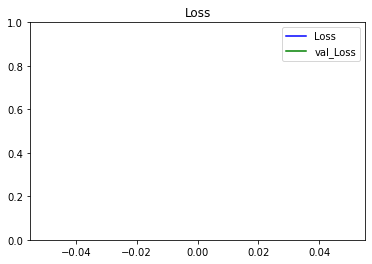

In [74]:
# function for plotting loss
def plot_metrics(train_metric, val_metric=None, metric_name=None, title=None, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(train_metric,color='blue',label=metric_name)
    if val_metric is not None: plt.plot(val_metric,color='green',label='val_' + metric_name)
    plt.legend(loc="upper right")

# plot loss history
plot_metrics(history.history['loss'], history.history['val_loss'], "Loss", "Loss", ylim=1.0)

In [75]:
# save model
if is_regression == True:
    label = "FinalModels/Valid_NNwithMACDreg_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"
if is_ltr == True:
    label = "FinalModels/Valid_PairwiseLTRwithMACD.tf"
else:
    label = "FinalModels/Valid_NNwithMACDclf_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"

ranknet.save(label)
print("Model saved to: " + label)
#loaded_model = tf.keras.models.load_model(label, compile = False)

INFO:tensorflow:Assets written to: FinalModels/Valid_PairwiseLTRwithMACD.tf\assets
Model saved to: FinalModels/Valid_PairwiseLTRwithMACD.tf


## 5e) Evaluate strategy
Two methods to convert pairs into rankings
- Bradley Terry and Elo models: convert sign(pred-0.5) into {-1, 1}
- simply sum all predictions {0 to 1} for each stock in a given month ==> current approach

In [96]:
#make predictions
tic = time()
#n_outputs = 1000000
n_outputs = len(xi_validate)
print(n_outputs)
model_output = ranknet.predict([xi_validate[:n_outputs], xj_validate[:n_outputs]])
toc = time()
print("make predictions:", toc - tic, "secs")

10226628
make predictions: 222.1064178943634 secs


In [97]:
model_output

array([[0.5],
       [0.5],
       [0.5],
       ...,
       [0.5],
       [0.5],
       [0.5]], dtype=float32)

In [98]:
#calc returns
k = 5
pct = 0.2
is_short = False
discretise = False
returns_matrix1_valid, weight_matrix1_valid, rank_table1_valid, _1 = get_Matrices_LTR(
                    model_output, df_validate, company_name = "PERMNO", pct = pct, is_short = is_short, max_ret = 10, discretise = False)
returns_matrix2_valid, weight_matrix2_valid, rank_table2_valid, _2 = get_Matrices_LTR(
                    model_output, df_validate, company_name = "PERMNO", pct = pct, is_short = is_short, max_ret = 10, discretise = True)
rets1_valid, cumrets1_valid = calc_returns(returns_matrix1_valid, weight_matrix = weight_matrix1_valid, k = k)
rets2_valid, cumrets2_valid = calc_returns(returns_matrix2_valid, weight_matrix = weight_matrix2_valid, k = k)

#plt.plot(cumrets_equal.index, cumrets_equal, label = "Equal-weighted index")
plt.plot(cumrets1_valid.index, cumrets1_valid, label = "LTR - probabilistic output")
#plt.plot(cumrets2_valid.index, cumrets2_valid, label = "LTR - discretised output")
plt.legend();
plt.xlabel("Date");
plt.xticks(rotation = 45);
plt.ylabel("Return")
plt.title("Long-only: " + str(pct*100) + "%");

IndexError: positional indexers are out-of-bounds

In [ ]:
regression_analysis(np.array(rets_equal),np.array(rets1_valid))

In [ ]:
#sharpe ratio
sharpe_valid = calc_sharpe(rets1_valid)
print("LTR probabilistic sharpe: ", sharpe_valid)
mdd_valid = calc_mdd(rets1_valid)
print("LTR probabilistic mdd: ", mdd_valid[0])
"""
sharpe_valid = calc_sharpe(rets2_valid)
print("LTR discretised sharpe: ", sharpe_valid)
mdd_valid = calc_mdd(rets2_valid)
print("LTR discretised mdd: ", mdd_valid[0])
"""
sharpe_equal = calc_sharpe(rets_equal)
print("Base index sharpe: ", sharpe_equal)
mdd_equal = calc_mdd(rets_equal)
print("Base index mdd: ", mdd_equal[0])

## 5e) Train RankNet with NDCG

In [71]:
# train model using compile and fit
learning_rate = 1e-3
ranknet = RankNet(hidden,dropout)
opt = optimizers.Adam(learning_rate=learning_rate)
#ranknet.compile(optimizer=opt, loss='binary_crossentropy',metrics=tfr.keras.metrics.get("ndcg", topn=5, name="NDCG@5"))
ranknet.compile(optimizer=opt, loss=tfr.keras.metrics.get("ndcg", topn=5, name="NDCG@5"),
    metrics=tfr.keras.metrics.get("ndcg", topn=5, name="NDCG@5"))

history = ranknet.fit([xi_train, xj_train], pij_train, epochs=3, batch_size=500, validation_data=([xi_test, xj_test], pij_test))

Epoch 1/3


ValueError: in user code:

    File "C:\Users\pyliu\anaconda3\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\pyliu\anaconda3\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\pyliu\anaconda3\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\pyliu\anaconda3\lib\site-packages\keras\engine\training.py", line 860, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\pyliu\anaconda3\lib\site-packages\keras\engine\training.py", line 918, in compute_loss
        return self.compiled_loss(
    File "C:\Users\pyliu\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\pyliu\anaconda3\lib\site-packages\keras\losses.py", line 136, in __call__
        with backend.name_scope(self._name_scope), graph_ctx:
    File "C:\Users\pyliu\anaconda3\lib\contextlib.py", line 113, in __enter__
        return next(self.gen)

    ValueError: 'NDCG@5' is not a valid root scope name. A root scope name has to match the following pattern: ^[A-Za-z0-9.][A-Za-z0-9_.\\/>-]*$


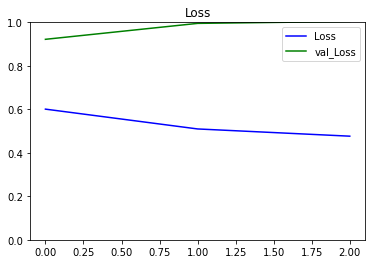

In [36]:
# function for plotting loss
def plot_metrics(train_metric, val_metric=None, metric_name=None, title=None, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(train_metric,color='blue',label=metric_name)
    if val_metric is not None: plt.plot(val_metric,color='green',label='val_' + metric_name)
    plt.legend(loc="upper right")

# plot loss history
plot_metrics(history.history['loss'], history.history['val_loss'], "Loss", "Loss", ylim=1.0)

In [352]:
# save model
if is_regression == True:
    label = "Models/NNreg_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"
if is_ltr == True:
    label = "Models/PairwiseLTR_NDCG.tf"
else:
    label = "Models/NNclf_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"

ranknet.save(label)
print("Model saved to: " + label)
#loaded_model = tf.keras.models.load_model(label, compile = False)

INFO:tensorflow:Assets written to: Models/PairwiseLTR.tf\assets
Model saved to: Models/PairwiseLTR.tf


## 5f) Evaluate strategy
Two methods to convert pairs into rankings
- Bradley Terry and Elo models: convert sign(pred-0.5) into {-1, 1}
- simply sum all predictions {0 to 1} for each stock in a given month ==> current approach

In [37]:
#make predictions
tic = time()
#n_outputs = 1000000
n_outputs = len(xi_test)
print(n_outputs)
model_output = ranknet.predict([xi_test[:n_outputs], xj_test[:n_outputs]])
toc = time()
print("make predictions:", toc - tic, "secs")

11507828
make predictions: 384.26697611808777 secs


In [38]:
#calc returns
k = 3
pct = 0.1
is_short = False
discretise = False
returns_matrix1, weight_matrix1, rank_table1, _1 = get_Matrices_LTR(
                    model_output, df_test, company_name = "TICKER", pct = pct, is_short = is_short, max_ret = 10, discretise = True)
returns_matrix2, weight_matrix2, rank_table2, _2 = get_Matrices_LTR(
                    model_output, df_test, company_name = "TICKER", pct = pct, is_short = is_short, max_ret = 10, discretise = False)
rets1, cumrets1 = calc_returns(returns_matrix1, weight_matrix = weight_matrix1, k = k)
rets2, cumrets2 = calc_returns(returns_matrix2, weight_matrix = weight_matrix2, k = k)

#calculate return & weight matrix for base strat - i.e. long 100%

plt.plot(cumrets_equal.index, cumrets_equal, label = "Equal-weighted index")
plt.plot(cumrets1.index, cumrets1, label = "LTR - discretise output")
plt.plot(cumrets2.index, cumrets2, label = "LTR - probabilistic output")
plt.legend();
plt.xlabel("Date");
plt.xticks(rotation = 45);
plt.ylabel("Return")
plt.title("Long-only: " + str(pct*100) + "%");

KeyError: "['TICKER'] not in index"

In [ ]:
regression_analysis(np.array(rets_equal),np.array(rets1))

In [101]:
#sharpe ratio
sharpe = calc_sharpe(rets1)
print("LTR discretised sharpe: ", sharpe)
mdd = calc_mdd(rets1)
print("LTR discretised mdd: ", mdd[0])

sharpe = calc_sharpe(rets2)
print("LTR probabilistic sharpe: ", sharpe)
mdd = calc_mdd(rets2)
print("LTR probabilistic mdd: ", mdd[0])

sharpe_equal = calc_sharpe(rets_equal)
print("Base index sharpe: ", sharpe_equal)
mdd_equal = calc_mdd(rets_equal)
print("Base index mdd: ", mdd_equal[0])

LTR discretised sharpe:  0.17329528410918518
LTR discretised mdd:  0.8289862085002205
LTR probabilistic sharpe:  0.6343763419437249
LTR probabilistic mdd:  0.4891196628947123
Base index sharpe:  0.6120306030872815
Base index mdd:  0.5304379670749022
